<a href="https://colab.research.google.com/github/docmhvr/Deep_Learning_with_Pytorch/blob/main/Evaluation_metrics_Reference_TorchMetrics/Classification_Evaluation_Metrics_using_Torchmetrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="font-size:30px;">Classification Evaluation Metrics using TorchMetrics</h1>

In the previous notebook, you learned how to implement evaluation metrics for classification from scratch. But we need not always do that. Libraries like Scikit-Learn already provide such functionalities. In fact, we can also use all those metrics from the `TorchMetrics` package. And that is exactly what we will be doing in this notebook.

<img src = "https://opencv.org/wp-content/uploads/2023/05/c3-week3-classification-eval-metrics.png" width=1000>

## Table of Contents
* [1 Classification Evaluation Metrics](#1-Classification-Evaluation-Metrics)
* [2 Generate Dataset](#2-Generate-Dataset)
* [3 Create a Logistic Regression Model](#3-Create-a-Logistic-Regression-Model)
* [4 Training and Prediction](#4-Training-and-Prediction)
* [5 Confusion Matrix](#5-Confusion-Matrix)
* [6 Accuracy](#6-Accuracy)
* [7 Precision](#7-Precision)
* [8 Recall / Sensitivity](#8-Recall-/-Sensitivity)
* [9 F1-Score](#9-F1-Score)
* [10 ROC-Curve](#10-ROC-Curve)


## 1 Classification Evaluation Metrics

For the sake of simplicity, we will illustrate the performance metrics for the task of point classification to two classes: `[0, 1]`.

The code till training and prediction section will remain exactly the same as the previous notebook.

To begin with, let's import all of the required packages.

Since we are going to perform binary classification in this notebook, we shall import all the relevant **Binary** evaluation metrics from TorchMetrics.

In [ ]:
# Uncooment the line below, if you are using Colab.
!pip install torchinfo torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 21.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import torch
import torch.nn as nn

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

from torchmetrics.classification import (
            BinaryAccuracy,
            BinaryConfusionMatrix,
            BinaryPrecision,
            BinaryRecall,
            BinaryF1Score,
            BinaryROC,
            BinaryAUROC
)


from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

matplotlib.style.use('ggplot')
plt.rcParams["figure.figsize"] = (10, 7)
%matplotlib inline

In [ ]:
bold = f"\033[1m"
reset = f"\033[0m"

## 2 Generate Dataset

For our purposes, we need to create a dataset. We use
[make_classification](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html)
function from scikit-learn library. It generates a random n-class classification problem with normally distributed
clusters of points. We also add uniformly distributed points as noise to our data.

To get the details about the functon `sklearn.datasets.make_classification` read
<a href="https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html" target=_blank>here</a>.

Inputs (X) shape: (100, 2)
Lables (y) shape: (100,)


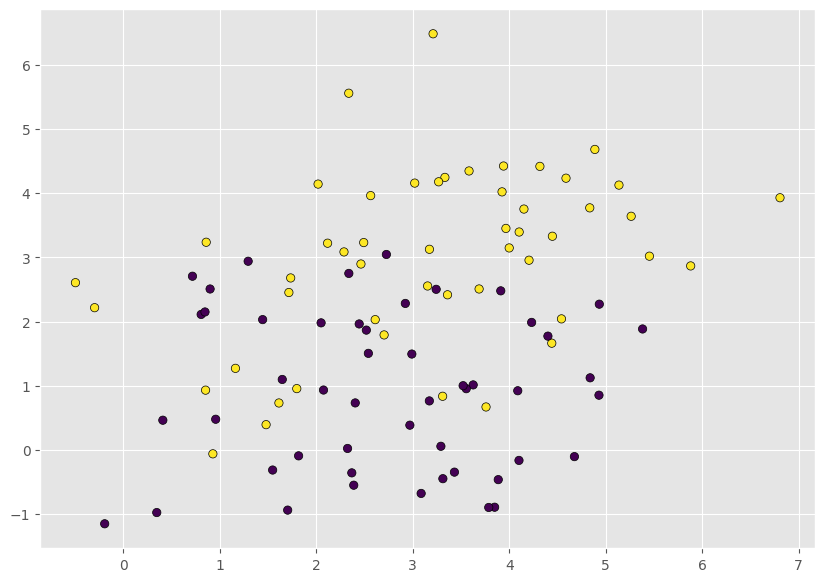

In [ ]:
# for reproducible results
seed = 42
rng = np.random.RandomState(seed)
torch.manual_seed(seed)


# generate two class classification problem
X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=seed, n_clusters_per_class=1
)

# add unifom random noise
X += 4 * rng.uniform(size=X.shape)

print(f"Inputs (X) shape: {X.shape}")
print(f"Lables (y) shape: {y.shape}")

plt.scatter(X[:,0],X[:,1],c=y,edgecolor='k')
plt.show()

## 3 Create a Logistic Regression Model

Here we will train a [Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression) classifier. Logistic regression is equivalent to a one-layer neural network with sigmoid activation.

We are using sigmoid activation, so the model prediction will be the prediction probability of class 1.

Basically, logistic regression is equivalent to a one-layer neural network, so let's implement it with PyTorch using the `nn` module.
The output vector `y_predicted` consists of the predicted estimations on whether the points belong to the class with
label '1'.


The `LogisticRegression` class  follows these methods:


**`__init__`:**  It takes `n_features` (number of input data features) and initiates `nn-linear` function.

**`forward`:** It takes `x` (data input) and does forward pass of the network.

In [ ]:
# Two-class logistic regression model.
class LogisticRegression(nn.Module):
    def __init__(self, n_features):
        super().__init__()

        # define linear layer (WX + B)
        self.linear = nn.Linear(n_features, 1, bias=True)

    def forward(self, x):
        # calculate WX + B
        x = self.linear(x)

        # sigmoid activation (prediction probability of class 1)
        predictions = torch.sigmoid(x)
        return predictions

## 4 Training and Prediction

### 4.1 Create the `Trainer` class

Since PyTorch does not provide unified methods for training, we create a simple `Trainer` class to fit our model and make predictions.

The **`Trainer` class follows these methods:**

**`__init__`:**

It takes three arguments.
        
- `model`: This has to be trained. Although we will pass the above-defined Linear Regression Model here, it can take any PyTorch model.

- `criterion`: It  takes any NN-module loss function.
        
- `optimizer`: It takes the optimizer algorithm method.
        
- `epoch_num`: Number of epochs for training.

**`fit`:** It takes two arguments, input and target.

This method does the following:
1. Forward pass of the `model`  with the `input`.

1. Finds loss, using forward pass and `target`.

1. Finds `gradient`, using `backprop`.

1. Updates parameters using, `step`

**`predict`:** It takes `input` as an argument. Only does forward pass and returns prediction.


In [ ]:
class Trainer:
    def __init__(self, model, criterion, optimizer, epoch_num):
        self.model = model

        # loss function
        self.criterion = criterion

        # Optimizer
        self.optimizer = optimizer

        # num of epochs
        self.epoch_num = epoch_num

    def fit(self, inputs, targets):
        """
        Updating model trainable parameters in loop for given number of epochs
        """

        # set model in train state.
        # Why this (and model.eval()) is important,
        # we will see when we will train a deep neural network.
        self.model.train()

        # run train loop for given epochs
        for epoch_idx in range(self.epoch_num):

            # reset previously calculated gradient to zero
            self.optimizer.zero_grad()

            # predict probability of class '1'
            preds = self.model(inputs).squeeze(dim=-1)

            # get loss
            loss = self.criterion(preds, targets)

            # calculate gradients
            loss.backward()

            # update parameters with gradient
            self.optimizer.step()

            # Calculate Binary Accuracy.
            pred_cls = (preds.squeeze(dim=-1) > 0.5).int()
            correct = (pred_cls == targets).sum()
            bin_acc = float(correct/len(targets))

            status = f"{f'{bold}[ Epoch: {epoch_idx+1} ]{reset}':=^80}\n"
            status += f"Loss: {loss.item():.4f} Accuracy: {bin_acc:.4f}"
            print(status)
            print("\n")

    def predict(self, inputs):

        # set model in train state.
        self.model.eval()
        # temporarily set requires_grad flag to false
        with torch.no_grad():
            # probability of class one prediction
            preds = self.model(inputs)
        return preds

Before We need to split our data to train and test sets and feed it to the <a href="https://en.wikipedia.org/wiki/Logistic_regression" target=_blank>Logistic Regression</a> classifier.

We perform the following steps during training and evaluation:

* Divide the data into `train` (75%) and `test` data (25 %).

* Create a model object using `LogisticRegression` model class.

* Define `criterion` as binary cross-entropy loss.

* Define `optimizer` as `SGD` optimizer.

* Create the trainer object.

* Train the model using the `fit` method defined in `Trainer` class.

* Finally, get predictions for test data.

In [ ]:
# Divide data into train (0.75) and test (0.25) set.
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

# train data from numpy to torch
x_train, y_train = torch.from_numpy(x_train).float(), torch.from_numpy(y_train).float()

# create model object
log_regression = LogisticRegression(n_features=2)

# define loss, in this case binary cross-entropy loss
criterion = nn.BCELoss()

# define optimizer, in this case Stochastic Gradient Descent
optimizer = torch.optim.SGD(log_regression.parameters(), lr=0.01)

# create trainer object
trainer = Trainer(log_regression, criterion, optimizer, 200)

# train the model
trainer.fit(x_train, y_train)

# test data from numpy to torch
x_test, y_test = torch.from_numpy(x_test).float(), torch.from_numpy(y_test).float()

# probability of class one prediction
y_predicted = trainer.predict(x_test)

==============================[ Epoch: 1 ]==============================
Loss: 1.0005 Accuracy: 0.5467


==============================[ Epoch: 2 ]==============================
Loss: 0.9870 Accuracy: 0.5467


==============================[ Epoch: 3 ]==============================
Loss: 0.9737 Accuracy: 0.5467


==============================[ Epoch: 4 ]==============================
Loss: 0.9606 Accuracy: 0.5467


==============================[ Epoch: 5 ]==============================
Loss: 0.9477 Accuracy: 0.5467


==============================[ Epoch: 6 ]==============================
Loss: 0.9350 Accuracy: 0.5467


==============================[ Epoch: 7 ]==============================
Loss: 0.9225 Accuracy: 0.5467


==============================[ Epoch: 8 ]==============================
Loss: 0.9102 Accuracy: 0.5467


==============================[ Epoch: 9 ]==============================
Loss: 0.8981 Accuracy: 0.5467


=============================[ Epoch: 10 ]=============

## 5 Confusion Matrix

<img src="https://www.learnopencv.com/wp-content/uploads/2020/01/c3_w3_confusion_matrix.png" width=600>

Let's assume class `1` is a **`positive`** class, and class `0` is **`negative`** class.

The [BinaryConfusionMatrix](https://torchmetrics.readthedocs.io/en/stable/classification/confusion_matrix.html#binaryconfusionmatrix) class in TorchMetrics is used to compute the Confusion matrix in binary classification.

The `compute()` function returns the final confusion matrix whose i-th row and j-th column entry indicates the number of samples in the ground truth labels being i-th class and predicted label being j-th class.

***Note***: *The true labels and predicted values should have the same dimension. Therefore, in the following code block, we are removing the last dimension in `y_predicted` using `squeeze`.*

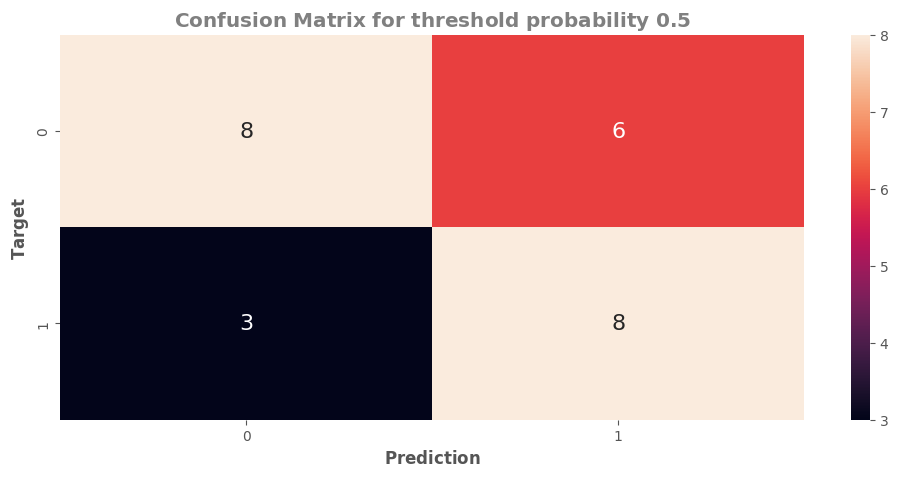

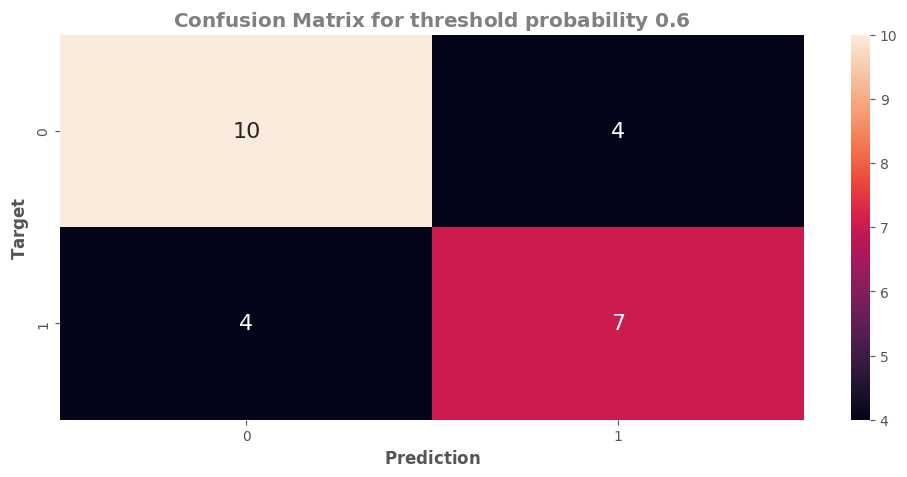

In [ ]:
# threshold probability 0.5
cm_t1 = BinaryConfusionMatrix(threshold=0.5)
cm_t1.update(y_predicted.squeeze(-1), y_test)
cm_t1_final = cm_t1.compute().numpy()

plt.figure(figsize=[12, 5])
sns.heatmap(cm_t1_final, annot=True, fmt='d', annot_kws={"size": 16})
plt.xlabel(r"$\bf{Prediction}$")
plt.ylabel(r"$\bf{Target}$")
plt.title(r"$\bf{Confusion\ Matrix\ for\ threshold\ probability\ 0.5}$", color="gray")
plt.show()

print("\n")

# threshold probability 0.6
cm_t2 = BinaryConfusionMatrix(threshold=0.6)
cm_t2.update(y_predicted.squeeze(-1), y_test)
cm_t2_final = cm_t2.compute().numpy()

plt.figure(figsize=[12, 5])
sns.heatmap(cm_t2_final, annot=True, fmt='d', annot_kws={"size": 16})
plt.xlabel(r"$\bf{Prediction}$")
plt.ylabel(r"$\bf{Target}$")
plt.title(r"$\bf{Confusion\ Matrix\ for\ threshold\ probability\ 0.6}$", color="gray")
plt.show()


The `BinaryConfusionMatrix` class also has provisions for normalizing the confusion matrix over the targets (`true`) or across the predictions (`pred`). This is achieved by passing in the `normalize` argument with the appropriate string.

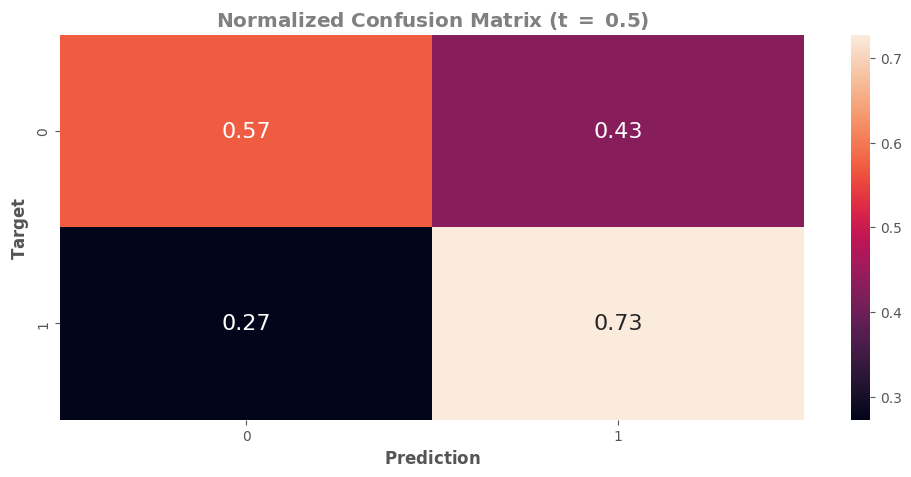

In [ ]:
cm_norm = BinaryConfusionMatrix(threshold=0.5, normalize="true")
cm_norm.update(y_predicted.squeeze(-1), y_test)
cm_norm_final = cm_norm.compute().numpy()

plt.figure(figsize=[12, 5])
sns.heatmap(cm_norm_final, annot=True, annot_kws={"size": 16})
plt.xlabel(r"$\bf{Prediction}$")
plt.ylabel(r"$\bf{Target}$")
plt.title(r"$\bf{Normalized\ Confusion\ Matrix\ (t\ = \ 0.5)}$", color="gray")
plt.show()

## 6 Accuracy

<img src="https://www.learnopencv.com/wp-content/uploads/2020/01/c3_w3_accuracy.png" width=600>

$$
accuracy = \frac{TP + TN}{TF + FP + FN + TN }
$$

We can use [BinaryAccuracy](https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html#binaryaccuracy) class to calculate the accuracy. We just need to update the `y_predicted` and `y_test` tensors, and initialize the class with the appropriate `threshold`.

***Note***: *The true labels and predicted values should have the same dimension. Therefore, in the following code block, we are removing the last dimension in `y_predicted` using `squeeze`.*

In [ ]:
accuracy = BinaryAccuracy(threshold=0.5)

accuracy.update(y_predicted.squeeze(-1), y_test)

print(f"Accuracy for threshold probability 0.5: {bold}{accuracy.compute():.4f}{reset}")

Accuracy for threshold probability 0.5: 0.6400


## 7 Precision

<img src="https://www.learnopencv.com/wp-content/uploads/2020/01/c3_w3_precision.png" width=600>

$$
precision = \frac{TP}{TP + FP}
$$

To calculate the precision value at a certain threshold, we can use `BinaryPrecision` class. See the docs [here](https://torchmetrics.readthedocs.io/en/stable/classification/precision.html#binaryprecision).

***Note***: *The true labels and predicted values should have the same dimension. Therefore, in the following code block, we are removing the last dimension in `y_predicted` using `squeeze`.*

In [ ]:
precision = BinaryPrecision(threshold=0.5)

precision.update(y_predicted.squeeze(-1), y_test)

print(f"Precision for threshold probability 0.5: {bold}{precision.compute():.4f}{reset}")

Precision for threshold probability 0.5: 0.5714


## 8 Recall / Sensitivity

<img src='https://www.learnopencv.com/wp-content/uploads/2020/01/c3_w3_recall.png' width=600>

$$
recall = \frac{TP}{TP + FN}
$$

To calculate the precision value at a certain threshold, we can use `BinaryRecall` class. See the docs [here](https://torchmetrics.readthedocs.io/en/stable/classification/recall.html#binaryrecall).

***Note***: *The true labels and predicted values should have the same dimension. Therefore, in the following code block, we are removing the last dimension in `y_predicted` using `squeeze`.*

In [ ]:
recall = BinaryRecall(threshold=0.5)

recall.update(y_predicted.squeeze(-1), y_test)

print(f"Recall for threshold probability 0.5: {bold}{recall.compute():.4f}{reset}")

Recall for threshold probability 0.5: 0.7273


## 9 F-1 Score

$$
F_1 score = \frac{2 TP}{2TP + FP + FN}
$$


To calculate the precision value at a certain threshold, we can use `BinaryF1Score` class. See the docs [here](https://torchmetrics.readthedocs.io/en/stable/classification/f1_score.html#binaryf1score).

***Note***: *The true labels and predicted values should have the same dimension. Therefore, in the following code block, we are removing the last dimension in `y_predicted` using `squeeze`.*

In [ ]:
f1_score = BinaryF1Score(threshold=0.5)

f1_score.update(y_predicted.squeeze(-1), y_test)

print(f"F1-Score for threshold probability 0.5: {bold}{f1_score.compute():.4f}{reset}")

F1-Score for threshold probability 0.5: 0.6400


## 10 ROC Curve

<img src="https://www.learnopencv.com/wp-content/uploads/2020/01/c3_w3_roc.png" width=700>


\begin{align}
TPR (recall) &= \frac{TP}{TP + FN} \\
FPR &= \frac{FP}{FP + TN} \\
\end{align}

### 10.1 ROC Curve Using Confusion Matrix

To calculate the true positive rates (TPR) and false-positive rates (FPR), we can use `BinaryROC` class. See the docs [here](https://torchmetrics.readthedocs.io/en/stable/classification/roc.html#binaryroc).

***Note***: *The true labels and predicted values should have the same dimension. Therefore, in the following code block, we are removing the last dimension in `y_predicted` using `squeeze`. Besides, the targets should be of `int` tensor.*

We can either manually pass the thresholds to obtain the FPR and TPR, or let the `BinaryROC` class dynamically choose the thresholds from the data (might be computationally a bit more expensive).


Finally, we plot `TPR-vs-FPR`.

In [ ]:
thresholds = torch.linspace(0.001, 0.999, 1000)

roc = BinaryROC(thresholds=thresholds)

roc.update(y_predicted.squeeze(-1), y_test.int())

fp_rates, tp_rates, _ = roc.compute()

**Let's plot `true positive rate` vs `false positive rate`.**

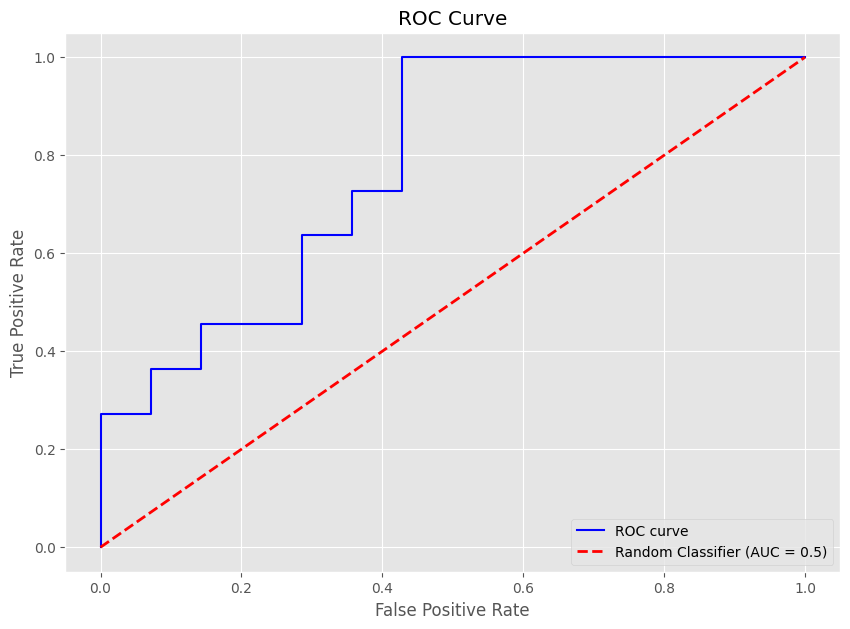

In [ ]:
plt.plot(fp_rates, tp_rates, label='ROC curve', color='b')
plt.plot([0, 1], [0, 1], label='Random Classifier (AUC = 0.5)', linestyle='--', lw=2, color='r')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC Curve')
plt.show()

### 10.2 Area Under the ROC Curve

To calculate the area under the **ROC** curve, we can use `BinaryAUROC` class. See the docs [here](https://torchmetrics.readthedocs.io/en/stable/classification/auroc.html#binaryauroc).

***Note***: *The true labels and predicted values should have the same dimension. Therefore, in the following code block, we are removing the last dimension in `y_predicted` using `squeeze`. Besides, the targets should be of `int` tensor.*

We can either manually pass the thresholds to obtain the area under the curve, or let the `BinaryAUROC` class dynamically choose the thresholds from the data.

In [ ]:
thresholds = torch.linspace(0.001, 0.999, 1000)

binary_auroc = BinaryAUROC(thresholds=thresholds)

binary_auroc.update(y_predicted.squeeze(-1), y_test.int())

print(f"AU-ROC Score: {bold}{binary_auroc.compute():.4f}{reset}")

AU-ROC Score: 0.7792
